<img src='netflix-q.jpg'>

# Business Problem

## Problem Description 

<p>
Netflix is all about connecting people to the movies they love. To help customers find those movies, they developed world-class movie recommendation system: CinematchSM. Its job is to predict whether someone will enjoy a movie based on how much they liked or disliked other movies. Netflix use those predictions to make personal movie recommendations based on each customer’s unique tastes. And while <b>Cinematch</b> is doing pretty well, it can always be made better.
</p>
<p>Now there are a lot of interesting alternative approaches to how Cinematch works that netflix haven’t tried. Some are described in the literature, some aren’t. We’re curious whether any of these can beat Cinematch by making better predictions. Because, frankly, if there is a much better approach it could make a big difference to our customers and our business.</p>
<p> Credits: https://www.netflixprize.com/rules.html </p>

## Problem Statement

<p>
Netflix provided a lot of anonymous rating data, and a prediction accuracy bar that is 10% better than what Cinematch can do on the same training data set. (Accuracy is a measurement of how closely predicted ratings of movies match subsequent actual ratings.) 
</p>

## Real world/Business Objectives and constraints

Objectives:
1. Predict the rating that a user would give to a movie that he has not yet rated.
2. Minimize the difference between predicted and actual rating (RMSE and MAPE)
<br>

Constraints:
1. Some form of interpretability.

# Machine Learning Problem

## Data 

### Data Overview

<p> Get the data from : https://www.kaggle.com/netflix-inc/netflix-prize-data/data </p>
<p> Data files : 
<ul> 
<li> combined_data_1.txt </li>
<li> combined_data_2.txt </li>
<li> combined_data_3.txt </li>
<li> combined_data_4.txt </li>
<li> movie_titles.csv </li>
</ul>
<pre>  
The first line of each file [combined_data_1.txt, combined_data_2.txt, combined_data_3.txt, combined_data_4.txt] contains the movie id followed by a colon. Each subsequent line in the file corresponds to a rating from a customer and its date in the following format:

CustomerID,Rating,Date

MovieIDs range from 1 to 17770 sequentially.
CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users.
Ratings are on a five star (integral) scale from 1 to 5.
Dates have the format YYYY-MM-DD.
</pre>

## Mapping the real world problem to a Machine Learning Problem

### Type of Machine Learning Problem 

For a given movie and user we need to predict the rating would be given by him/her to the movie. 
The given problem is a Recommendation problem 
It can also seen as a Regression problem

### Performance metric

<ul>
<li> Mean Absolute Percentage Error</li>
<li> Root Mean Square Error</li>
</ul>


### Machine Learning Objective and Constraints

1. Minimize RMSE.
2. Try to provide some interpretability.

In [1]:
# this is just to know how much time will it take to run this entire ipython notebook 
from datetime import datetime
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix


from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

# EDA

## Preprocessing

### Merging Whole Data from diff files

In [3]:
start = datetime.now()
if not os.path.isfile('data.csv'):
    #Final master file will be data.csv after merging all files
    data = open('data.csv',mode='w')
    
    row = list()
    files=['data_folder/combined_data_1.txt','data_folder/combined_data_2.txt', 
           'data_folder/combined_data_3.txt', 'data_folder/combined_data_4.txt']
    
    for file in files:
        print("Reading data from {}...".format(file))
        
        # with keyword ensures hat a resource is "cleaned up"
        # when the code that uses it finishes running
        with open(file) as f:
            for line in f:
                
                line = line.strip()
                if line.endswith(":"):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(":","")
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0,movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done \n")
    data.close()
print('Time Taken To complete this task: ',datetime.now()-start)

                
            

Reading data from data_folder/combined_data_1.txt...
Done 

Reading data from data_folder/combined_data_2.txt...
Done 

Reading data from data_folder/combined_data_3.txt...
Done 

Reading data from data_folder/combined_data_4.txt...
Done 

Time Taken To complete this task:  0:05:28.097725


##### Creating the DataFrame

In [2]:
start = datetime.now()
df = pd.read_csv('data.csv',sep = ',',
                names=['movie','user','rating','date'])
df.date = pd.to_datetime(df.date)
print("Convertion to Date Time format Done\n")

# We will be using Time Based split lets sort data according to time

df.sort_values(by='date',inplace=True)
print("Sorted By Date\n")

print("Time Taken: ",datetime.now() - start)


Convertion to Date Time format Done

Sorted By Date

Time Taken:  0:01:42.680068


In [3]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [5]:
df['rating'].describe()

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

### Checking null/NaN if any values

In [9]:
print("Null values in Cols?:\n",df.isnull().any());

Null values in Cols?:
 movie     False
user      False
rating    False
date      False
dtype: bool


Observation: There are no null vals in any col

### Checking Duplicates and Removing if Any

In [11]:
is_dup_present = df.duplicated(['movie','user','rating'])

# sum of all false will return 0
dups = sum(is_dup_present)

print("There are {} duplicates in Data Frame".format(dups))

There are 0 duplicates in Data Frame


### Stats

In [16]:
print("Total Data\n","*"*50)

print("\nNo.of Ratings: ",df.shape[0])
print("No of Users: ",len(np.unique(df['user'])))
print("No.of Movies: ",len(np.unique(df['movie'])))

Total Data
 **************************************************

No.of Ratings:  100480507
No of Users:  480189
No.of Movies:  17770


## Train and Test Split (80:20)

In [19]:
# Creating Csv files for Train and Test
start = datetime.now()

if not os.path.isfile('train.csv'):
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv",index=False)

if not os.path.isfile('test.csv'):
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv",index=False)

    


print("Time Taken: ",datetime.now()-start)

Time Taken:  0:14:03.463842


In [3]:
train_df = pd.read_csv("train.csv",parse_dates=['date'])
test_df = pd.read_csv("test.csv")

### Stats of Train Data

In [21]:
print("Train Data\n","*"*50)

print("\nNo.of Ratings: ",train_df.shape[0])
print("No of Users: ",len(np.unique(train_df['user'])))
print("No.of Movies: ",len(np.unique(train_df['movie'])))

Train Data
 **************************************************

No.of Ratings:  80384405
No of Users:  405041
No.of Movies:  17424


### Stats of Test Data

In [22]:
print("Test Data\n","*"*50)

print("\nNo.of Ratings: ",test_df.shape[0])
print("No of Users: ",len(np.unique(test_df['user'])))
print("No.of Movies: ",len(np.unique(test_df['movie'])))

Test Data
 **************************************************

No.of Ratings:  20096102
No of Users:  349312
No.of Movies:  17757


## EDA on Train Data

In [4]:
# method to make y-axis more readable
def humanReadableNums(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

<IPython.core.display.Javascript object>


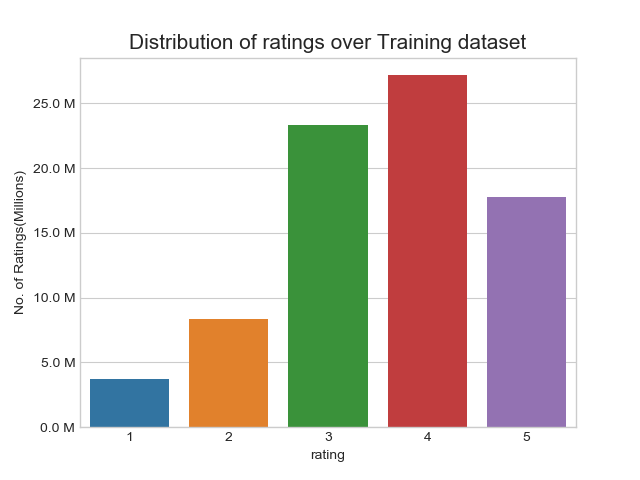

In [24]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating) #x-axis ratings
ax.set_yticklabels([humanReadableNums(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

##### Adding WEEK col to the df for Analysis

In [5]:
# It is used to skip the warning ''SettingWithCopyWarning''.. 
pd.options.mode.chained_assignment = None  # default='warn'

train_df['day_of_week'] = train_df.date.dt.weekday_name

train_df.head()

,movie,user,rating,date,day_of_week
0,10341,510180,4,1999-11-11,Thursday
1,1798,510180,5,1999-11-11,Thursday
2,10774,510180,3,1999-11-11,Thursday
3,8651,510180,2,1999-11-11,Thursday
4,14660,510180,2,1999-11-11,Thursday


### Lets Check No.Of Ratings per Month

<IPython.core.display.Javascript object>


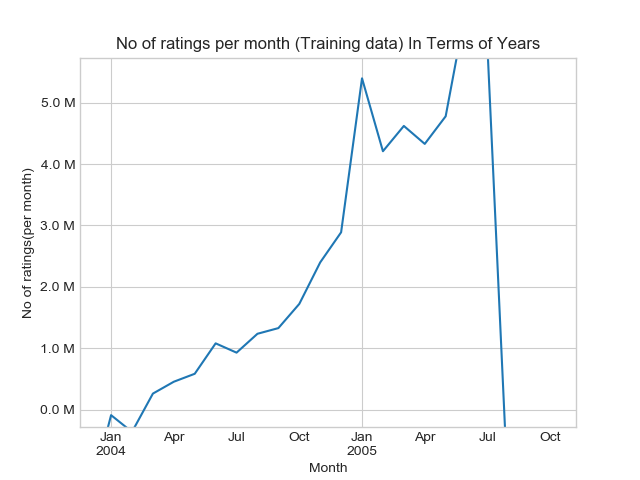

In [27]:
# its like group by on Month and counting no.of ratings in that group
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data) In Terms of Years')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([humanReadableNums(item, 'M') for item in ax.get_yticks()])
plt.show()

### Lets Check How many Movies were Rated by Each User

In [5]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

#### Plotting PDF and CDF

<IPython.core.display.Javascript object>


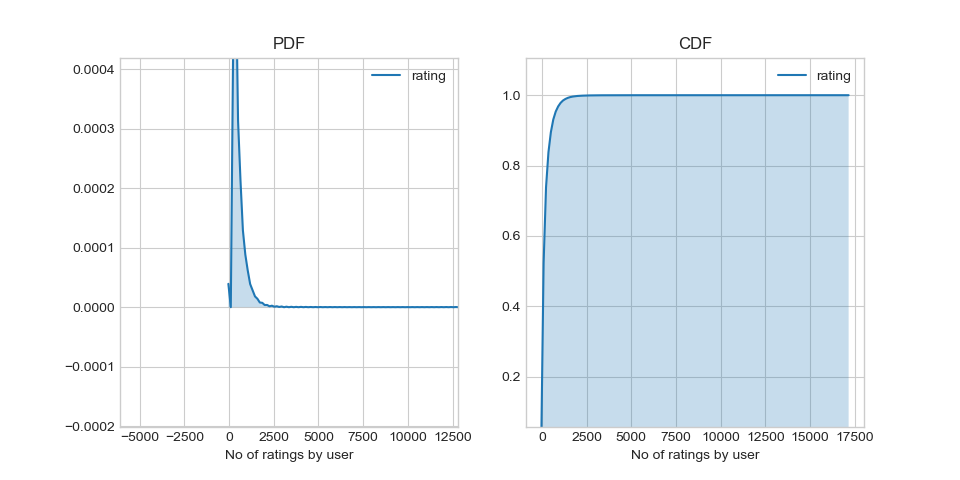

In [29]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

In [30]:
no_of_rated_movies_per_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

> Observation: We can See that 75 percentile of people rated nearly 245 movies

<IPython.core.display.Javascript object>


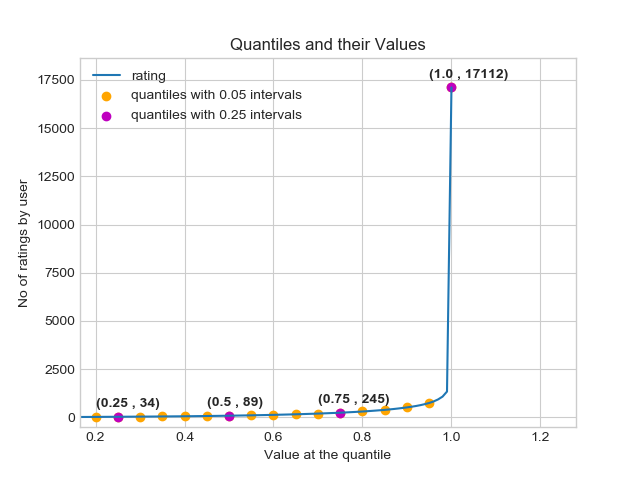

In [32]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')


plt.show()

In [43]:
quantiles[::5]

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17112
Name: rating, dtype: int64

In [44]:
print('\n No of ratings at last 5 percentile : {}\n'.format(sum(no_of_rated_movies_per_user>=749)) )


 No of ratings at last 5 percentile : 20305



> i.e Last 5 percentile Users have rated 20k movies

In [46]:
print('\n No of ratings at last 10 percentile : {}\n'.format(sum(no_of_rated_movies_per_user>=520)) )


 No of ratings at last 10 percentile : 40543



### Analysis of ratings of a movie given by a user

<IPython.core.display.Javascript object>


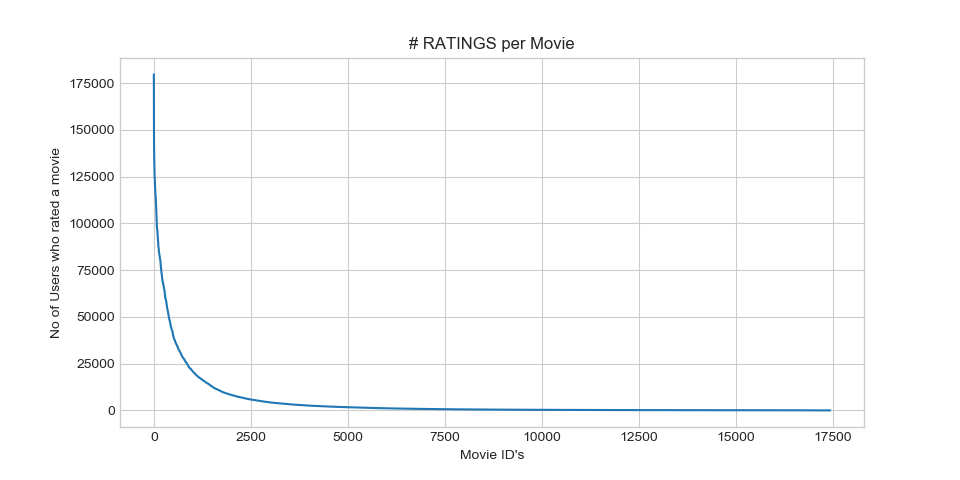

In [6]:
no_of_ratings_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
#ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel("Movie ID's")
plt.ylabel('No of Users who rated a movie')
#ax.set_xticklabels([])

plt.show()

In [51]:
quantiles = no_of_ratings_per_movie.quantile(np.arange(0,1.01,0.01), interpolation='higher')

In [52]:
quantiles

0.00         1
0.01         6
0.02        21
0.03        39
0.04        52
0.05        63
0.06        70
0.07        75
0.08        79
0.09        83
0.10        87
0.11        91
0.12        94
0.13        98
0.14       102
0.15       105
0.16       108
0.17       111
0.18       115
0.19       119
0.20       124
0.21       128
0.22       133
0.23       137
0.24       142
0.25       147
0.26       154
0.27       160
0.28       165
0.29       171
         ...  
0.71      1672
0.72      1795
0.73      1911
0.74      2038
0.75      2190
0.76      2348
0.77      2560
0.78      2795
0.79      3005
0.80      3296
0.81      3591
0.82      3944
0.83      4388
0.84      4888
0.85      5478
0.86      6056
0.87      6825
0.88      7741
0.89      8784
0.90     10139
0.91     11819
0.92     14349
0.93     16803
0.94     20023
0.95     24454
0.96     30365
0.97     38336
0.98     54303
0.99     78879
1.00    179684
Name: rating, Length: 101, dtype: int64

- __It is very skewed.. just like nunmber of ratings given per user.__
- There are some movies (which are very popular) which are rated by huge number of users.

### No.of Ratings on Each day of the Week

<IPython.core.display.Javascript object>


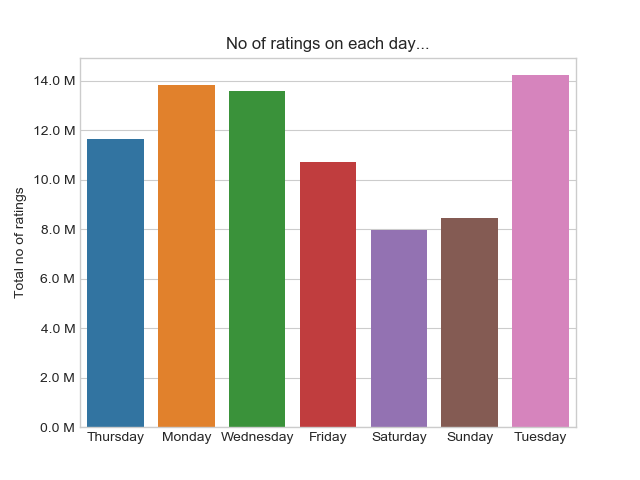

In [56]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_df, ax=ax)
plt.title('No of ratings on each day...')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([humanReadableNums(item, 'M') for item in ax.get_yticks()])
plt.show()

<IPython.core.display.Javascript object>


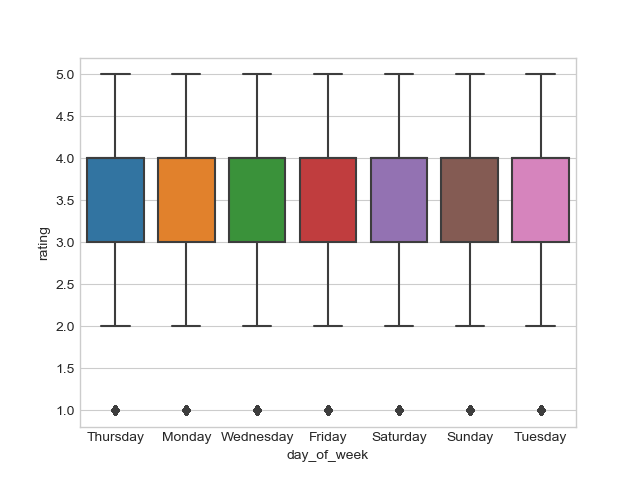

0:01:11.127056


In [57]:
start = datetime.now()
fig = plt.figure()
sns.boxplot(y='rating', x='day_of_week', data=train_df)
plt.show()
print(datetime.now() - start)

<IPython.core.display.Javascript object>


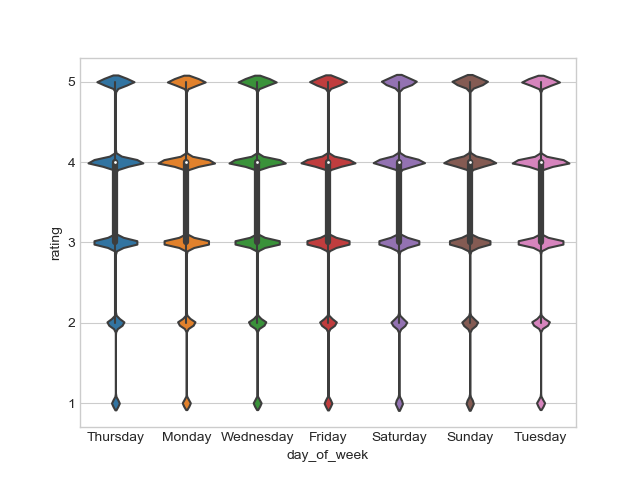

0:08:59.640751


In [58]:
start = datetime.now()
fig = plt.figure()
sns.violinplot(y='rating', x='day_of_week', data=train_df)
plt.show()
print(datetime.now() - start)

In [7]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()

print(" Average ratings")
print("-"*30)
print(avg_week_df)
print("\n")

 Average ratings
------------------------------
day_of_week
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64




> As its almost same on every day, This Metric we considered is not Important.

### Creating Sparse Matrix From Train Data

In [6]:
def convertToSparseAndStore(file,df):
    start = datetime.now()
    if os.path.isfile(file):
        print("It is present in your pwd, getting it from disk....")
        # just get it from the disk instead of computing it
        sparse_matrix = sparse.load_npz(file)
        print("DONE..")
        return sparse_matrix
    else: 
        print("We are creating sparse_matrix from the dataframe..")
        # create sparse_matrix and store it for after usage.
        # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
        # It should be in such a way that, MATRIX[row, col] = data
        sparse_matrix = sparse.csr_matrix((df.rating.values, (df.user.values,
                                                   df.movie.values)),)

        print('Done. It\'s shape is : (user, movie) : ',sparse_matrix.shape)
        print('Saving it into disk for furthur usage..')
        # save it into disk
        sparse.save_npz(file, sparse_matrix)
        print('Done..\n')
        return sparse_matrix

    print(datetime.now() - start)

In [7]:
train_sparse_matrix = convertToSparseAndStore('train_sparse_matrix.npz',train_df)

It is present in your pwd, getting it from disk....
DONE..


In [26]:
non_zero_ele = train_sparse_matrix.count_nonzero()
rows,cols = train_sparse_matrix.shape
print("Sparsity of Train Matrix: {}".format((1-(non_zero_ele/(rows*cols)))*100))

Sparsity of Train Matrix: 99.8292709259195


### Creating Sparse Matrix for Test Data

In [8]:
test_sparse_matrix = convertToSparseAndStore('test_sparse_matriz.npz',test_df)

It is present in your pwd, getting it from disk....
DONE..


In [28]:
non_zero_ele = test_sparse_matrix.count_nonzero()
rows,cols = test_sparse_matrix.shape
print("Sparsity of Test Matrix: {}".format((1-(non_zero_ele/(rows*cols)))*100))

Sparsity of Test Matrix: 99.95731772988694


### Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

In [22]:
train_sparse_matrix.shape

(2649430, 17771)

In [29]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    # Sparse_matrix.sum() will calc sum of col vals if axis=0
    # if axis =1 calcs rows sum
    
    #if axis=1 then it calcs sumof ratings of all mves given by 
    #particular user
    
    #if axis =0 then it calcs sumof ratings of particular movie 
    #given by all users
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    
    # no of ratings that each user OR movie..
    #is_rated.sum calcs sum(no.of trues) in the axis given
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
   
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

#### Global avg of all movie ratings

In [10]:
train_averages = dict()

# train_sparse_matrix.sum() give the sum of all ratings of all movies
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.5828906863215568}

> train_sparse_matrix is of the form [user,movie]=rating i.e matrix contains ratings of all movies given by each user

#### Avg rating per user

In [11]:
train_averages['user'] = get_average_ratings(train_sparse_matrix,of_users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])


Average rating of user 10 : 3.37810945274


> Here get_average_rating() is calculating sum along axis=1 i.e col, Its ntg but sum of ratings of all movies given by particular user divide by total no.of movies. 

#### Avg Rating per movie

In [12]:
train_averages['movie'] = get_average_ratings(train_sparse_matrix,of_users=False)
print('\n Average rating of movie 15 :',train_averages['movie'][15])


 Average rating of movie 15 : 3.30384615385


> Here get_average_ratings() is calculating sum along the axis=0 i.e row, Its ntg but sum of ratings given by all users to that particular movie divide by total no.of users.

<IPython.core.display.Javascript object>


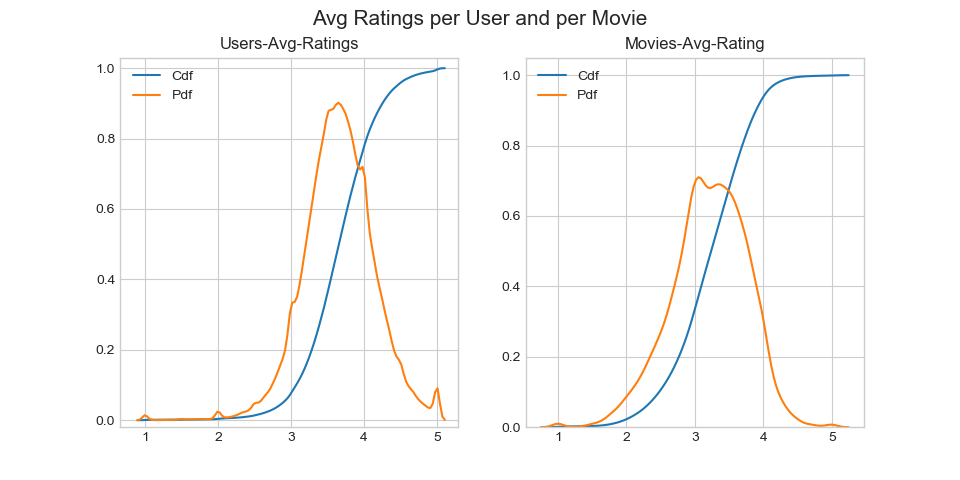

0:00:59.643836


In [61]:
start = datetime.now()
# draw pdfs for average rating per user and average
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)

ax1.set_title('Users-Avg-Ratings')
# get the list of average user ratings from the averages dictionary..
user_averages = [rat for rat in train_averages['user'].values()]
sns.distplot(user_averages, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(user_averages, ax=ax1, hist=False,label='Pdf')

ax2.set_title('Movies-Avg-Rating')
# get the list of movie_average_ratings from the dictionary..
movie_averages = [rat for rat in train_averages['movie'].values()]
sns.distplot(movie_averages, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(movie_averages, ax=ax2, hist=False, label='Pdf')

plt.show()
print(datetime.now() - start)

### Cold Start Problem

> What is Cold Start Problem?<br>
Ans) We have divided our data into train and test using Time split, here For example consider we have divided data like this from 2000 - 2014 as train data nad 2014 - 2017 as test data then some of the new users or movies present in test data  will not be in train data, this is called Cold Start Problem.

#### Cold Start Problem with Users

In [13]:
total_users = len(np.unique(df['user']))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 480189

Number of Users in Train data : 405041

No of Users that didn't appear in train data: 75148(15.65 %) 
 


> We need to handle __new users__ ( ___75148___ ) who didn't appear in train data.

#### Cold Start Problem with Movies 

In [14]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 17770

Number of Users in Train data : 17424

No of Movies that didn't appear in train data: 346(1.95 %) 
 


> We might have to handle __346 movies__ (small comparatively) in test data

## Computing Similarity Matrix

### Movie-Movie Similarity

In [11]:
start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    print("It seems you don't have that file. Computing movie_movie similarity...")
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    print("Done..")
    # store this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
    print("Done..")
else:
    print("It is there, We will get it.")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Done ...")

print("It's a ",m_m_sim_sparse.shape," dimensional matrix")

print(datetime.now() - start)

It is there, We will get it.
Done ...
It's a  (17771, 17771)  dimensional matrix
0:00:28.345309


In [14]:
m_m_sim_sparse.shape

(17771, 17771)

> Generally The top x similar movies matters, so we consider only that top x similar movies and store them in a dictionary

In [12]:
start = datetime.now()
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])
print(datetime.now() - start)

0:01:03.391454


In [13]:
start = datetime.now()
similar_movies = dict()
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]
print(datetime.now() - start)

# just testing similar movies for movie_15
similar_movies[15]

0:00:29.303320


array([ 8279,  8013, 16528,  5927, 13105, 12049,  4424, 10193, 17590,
        4549,  3755,   590, 14059, 15144, 15054,  9584,  9071,  6349,
       16402,  3973,  1720,  5370, 16309,  9376,  6116,  4706,  2818,
         778, 15331,  1416, 12979, 17139, 17710,  5452,  2534,   164,
       15188,  8323,  2450, 16331,  9566, 15301, 13213, 14308, 15984,
       10597,  6426,  5500,  7068,  7328,  5720,  9802,   376, 13013,
        8003, 10199,  3338, 15390,  9688, 16455, 11730,  4513,   598,
       12762,  2187,   509,  5865,  9166, 17115, 16334,  1942,  7282,
       17584,  4376,  8988,  8873,  5921,  2716, 14679, 11947, 11981,
        4649,   565, 12954, 10788, 10220, 10963,  9427,  1690,  5107,
        7859,  5969,  1510,  2429,   847,  7845,  6410, 13931,  9840,
        3706], dtype=int64)

In [12]:
movie_ids.shape

(17424,)

### Getting Most Similar Movies using Similarity Matrix

In [14]:
# First Let's load the movie details into soe dataframe..
# movie details are in 'netflix/movie_titles.csv'

movie_titles = pd.read_csv("data_folder/movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1")

movie_titles.head()

Tokenization took: 15.96 ms
Type conversion took: 90.59 ms
Parser memory cleanup took: 0.00 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


##### Similar Movies for 'Vampire Journals'

In [15]:
def getSimilarMovies(mv_id):
    
    mve_title = movie_titles.loc[mv_id].values[1];
    print("\nMovie ----->",mve_title)

    print("\nIt has {} Ratings from users.".format(train_sparse_matrix[:,mv_id].getnnz()))

    #m_m_sim_sparse[:,mv_id] gives col values .getnnz() gives non zero col vals
    print("\nWe have {} movies which are similar to this  and we will get only top most..".format(m_m_sim_sparse[:,mv_id].getnnz()))
    similarities = m_m_sim_sparse[mv_id].toarray().ravel()

    # It will sort and reverse the array and ignore its similarity (ie.,1)
    # and return its indices(movie_ids)
    sim_indices = similarities.argsort()[::-1][1:]

    similarities[sim_indices]
    
    plt.plot(similarities[sim_indices], label='All the ratings')
    plt.plot(similarities[sim_indices[:100]], label='top 100 similar movies')
    plt.title("Similar Movies of {} ".format(mve_title), fontsize=20)
    plt.xlabel("Movies (Not Movie_Ids)", fontsize=15)
    plt.ylabel("Cosine Similarity",fontsize=15)
    plt.legend()
    plt.show()
    
    print("Top 10 Similar Movies of: ",mve_title,"\n")
    print(movie_titles.loc[sim_indices[:10]])


Movie -----> Vampire Journals

It has 270 Ratings from users.

We have 17284 movies which are similar to this  and we will get only top most..


<IPython.core.display.Javascript object>


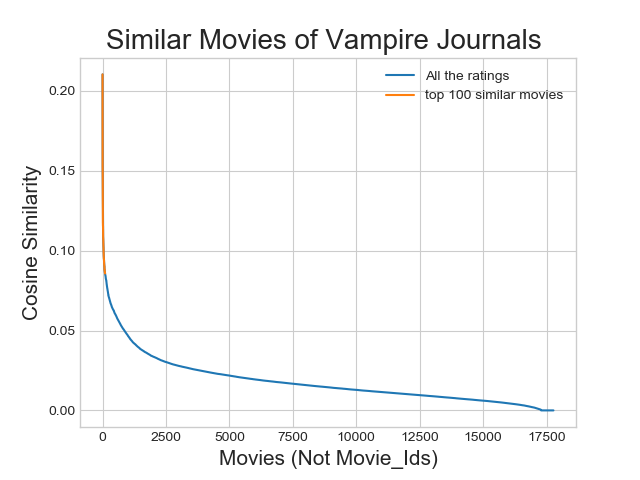

Top 10 Similar Movies of:  Vampire Journals 

          year_of_release                     title
movie_id                                           
323                1999.0           Modern Vampires
4044               1998.0  Subspecies 4: Bloodstorm
1688               1993.0   To Sleep With a Vampire
13962              2001.0  Dracula: The Dark Prince
12053              1993.0            Dracula Rising
16279              2002.0     Vampires: Los Muertos
4667               1996.0                Vampirella
1900               1997.0              Club Vampire
13873              2001.0                 The Breed
15867              2003.0     Dracula II: Ascension


In [71]:
getSimilarMovies(67)

##### Similar Movies of 'Vikings'


Movie -----> The Vikings

It has 1890 Ratings from users.

We have 17319 movies which are similar to this  and we will get only top most..


<IPython.core.display.Javascript object>


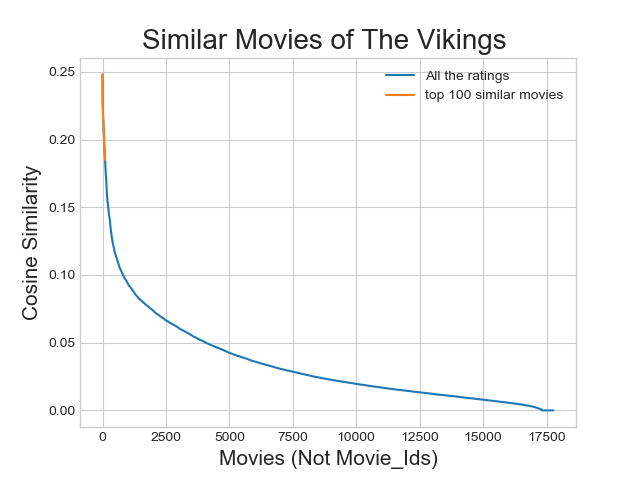

Top 10 Similar Movies of:  The Vikings 

          year_of_release                     title
movie_id                                           
16401              1968.0                Will Penny
3955               1959.0        The Horse Soldiers
173                1968.0       The Devil's Brigade
11855              1967.0                    Hombre
4133               1955.0            The Kentuckian
6827               1949.0     Wake of the Red Witch
535                1960.0                 The Alamo
7547               1949.0  She Wore a Yellow Ribbon
14554              1965.0             In Harm's Way
6229               1953.0                  The Robe


In [72]:
getSimilarMovies(3376)

##### Similar Movies of The Fast and Furious


Movie -----> The Fast and the Furious

It has 84839 Ratings from users.

We have 17396 movies which are similar to this  and we will get only top most..


<IPython.core.display.Javascript object>


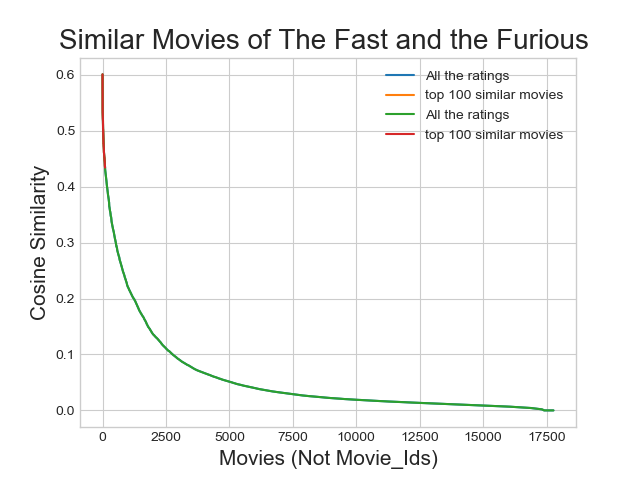

Top 10 Similar Movies of:  The Fast and the Furious 

          year_of_release                 title
movie_id                                       
4996               2000.0    Gone in 60 Seconds
14718              2002.0  XXX: Special Edition
9756               2002.0             Mr. Deeds
14712              2001.0           Tomb Raider
3638               2003.0           Bad Boys II
16242              1997.0               Con Air
483                2001.0           Rush Hour 2
1307               2003.0              S.W.A.T.
3427               2002.0       Men in Black II
6972               1998.0            Armageddon


In [70]:
getSimilarMovies(6844)

In [76]:
train_df.head()

,movie,user,rating,date,day_of_week
0,10341,510180,4,1999-11-11,Thursday
1,1798,510180,5,1999-11-11,Thursday
2,10774,510180,3,1999-11-11,Thursday
3,8651,510180,2,1999-11-11,Thursday
4,14660,510180,2,1999-11-11,Thursday


# Machine Learning Models

<img src='models.jpg' width=500px>

In [17]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

## Sampling Data

### Sample Train Data

In [19]:
start = datetime.now()
path = "data_folder/sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else: 
    # get 10k users and 1k movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=10000, no_movies=1000,
                                             path = path)

print(datetime.now() - start)

Original Matrix : (users, movies) -- (405041 17424)
Original Matrix : Ratings -- 80384405

Sampled Matrix : (users, movies) -- (10000 1000)
Sampled Matrix : Ratings -- 129286
Saving it into disk for furthur usage..
Done..

0:00:40.257354


### Sample Test Data

In [24]:
start = datetime.now()

path = "data_folder/sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    # get 5k users and 500 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=5000, no_movies=500,
                                                 path = path)
print(datetime.now() - start)

Original Matrix : (users, movies) -- (349312 17757)
Original Matrix : Ratings -- 20096102

Sampled Matrix : (users, movies) -- (5000 500)
Sampled Matrix : Ratings -- 7333
Saving it into disk for furthur usage..
Done..

0:00:09.686355


## Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)

In [25]:
sample_train_averages = dict()

### Global avg of all movie ratings

In [26]:
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.581679377504138}

### Avg Rating per USER

In [30]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 1515220 :',sample_train_averages['user'][1515220])


Average rating of user 1515220 : 3.9655172413793105


### Avg Rating per Movie

In [31]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15153 :',sample_train_averages['movie'][15153])


 AVerage rating of movie 15153 : 2.6458333333333335


## Featurizing Data

In [32]:
print('\n No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('\n No of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))


 No of ratings in Our Sampled train matrix is : 129286


 No of ratings in Our Sampled test  matrix is : 7333



### Featurizing Data for Regression Problem

#### Featurizing Train Data

In [33]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [34]:
'''
############################################################
# It took me almost 10 hours to prepare this train dataset.#
############################################################
start = datetime.now()
if os.path.isfile('data_folder/reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('sample/small/reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)
'''

'\n############################################################\n# It took me almost 10 hours to prepare this train dataset.#\n############################################################\nstart = datetime.now()\nif os.path.isfile(\'sample/small/reg_train.csv\'):\n    print("File already exists you don\'t have to prepare again..." )\nelse:\n    print(\'preparing {} tuples for the dataset..\n\'.format(len(sample_train_ratings)))\n    with open(\'sample/small/reg_train.csv\', mode=\'w\') as reg_data_file:\n        count = 0\n        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):\n            st = datetime.now()\n        #     print(user, movie)    \n            #--------------------- Ratings of "movie" by similar users of "user" ---------------------\n            # compute the similar Users of the "user"        \n            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()\n            to

In [35]:
reg_train = pd.read_csv('data_folder/reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()


,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5


-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this user.. )


- __UAvg__ : User's Average rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

#### Featurizing Test Data

In [36]:
# get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [37]:
sample_train_averages['global']

3.581679377504138

In [38]:
'''start = datetime.now()

if os.path.isfile('data_folder/reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('sample/small/reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  
'''

'start = datetime.now()\n\nif os.path.isfile(\'sample/small/reg_test.csv\'):\n    print("It is already created...")\nelse:\n\n    print(\'preparing {} tuples for the dataset..\n\'.format(len(sample_test_ratings)))\n    with open(\'sample/small/reg_test.csv\', mode=\'w\') as reg_data_file:\n        count = 0 \n        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):\n            st = datetime.now()\n\n        #--------------------- Ratings of "movie" by similar users of "user" ---------------------\n            #print(user, movie)\n            try:\n                # compute the similar Users of the "user"        \n                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()\n                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring \'The User\' from its similar users.\n                # get the ratings of most similar users for this movie\n                top_ratings

In [40]:
reg_test_df = pd.read_csv('data_folder/reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4


-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 simiular users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 simiular movies rated by this user.. )


- __UAvg__ : User AVerage rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

### Transforming Data for Surprise Model
(Used for Recommendation Systems) http://surpriselib.com/
<br>
It Supports SKLearn<br>

It Accepts data of the form: from file of Data Frame<br>

http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py

In [41]:
from surprise import Reader, Dataset

#### Transforming Train Data

In [42]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

#### Transforming Test Data

Testset is just a list of (user, movie, rating) tuples. (Order in the tuple is impotant)

In [47]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

## Applying ML Models

-  Global dictionary that stores rmse and mape for all the models....

    - It stores the metrics in a dictionary of dictionaries

    > __keys__ : model names(string)

    > __value__: dict(__key__ : metric, __value__ : value ) 

In [48]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

##### Util Funcs for Running Regression Models

In [49]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

###################################################################
###################################################################
def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results
    

##### Util Funcs for Surprise Models

In [51]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

##################################################################################
# It will return predicted ratings, rmse and mape of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

### Applying XGBoost on our df with 13 Features

Training the model..
[20:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.

[20:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

<IPython.core.display.Javascript object>


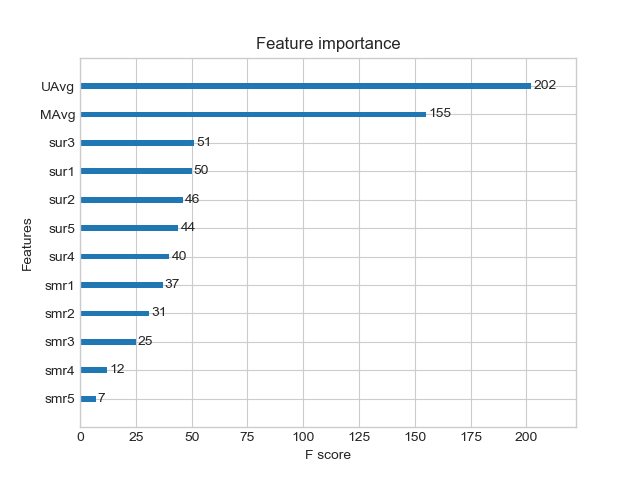

In [59]:
import xgboost as xgb
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

### Surprise Baseline Model

In [60]:
from surprise import BaselineOnly 

http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly

__Predicted_rating : ( baseline prediction ) __

>$   \large {\hat{r}_{ui} = b_{ui} =\mu + b_u + b_i} $


- $\pmb \mu $ : Average of all Ratings in training data.
- $\pmb b_u$ : User bias
- $\pmb b_i$ : Item bias (movie biases) 

__Optimization function ( Least Squares Problem ) __

    - http://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baselines-estimates-configuration 

> $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right).\text {        [mimimize } {b_u, b_i]}$ 

In [62]:

# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:00.719105 

Evaluating the model with train data..
time taken : 0:00:00.885603
---------------
Train Data
---------------
RMSE : 0.9347153928678286

MAPE : 29.389572652358183

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.066819
---------------
Test Data
---------------
RMSE : 1.0730330260516174

MAPE : 35.04995544572911

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:01.672525


In [63]:
models_evaluation_train['bsl_algo']

{'rmse': 0.9347153928678286,
 'mape': 29.389572652358183,
 'predictions': array([3.89898205, 3.37140265, 3.3237082 , ..., 3.40556302, 3.54788112,
        3.6428903 ])}

### XGBoost if 13 Features + Surprise Baseline Predictor

i.e Taking above output and adding it to our df

#### Updating Train Data

In [64]:
# add our baseline_predicted value as our feature..
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,3.898982
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.371403


#### Updating Test Data

In [65]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679


##### Again Building Modle with newly added feature(14 features)

Training the model..
[20:14:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:14:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:14:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:14:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:14:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:14:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:14:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.

[20:14:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:14:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:14:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:14:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:14:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:14:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[20:14:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

<IPython.core.display.Javascript object>


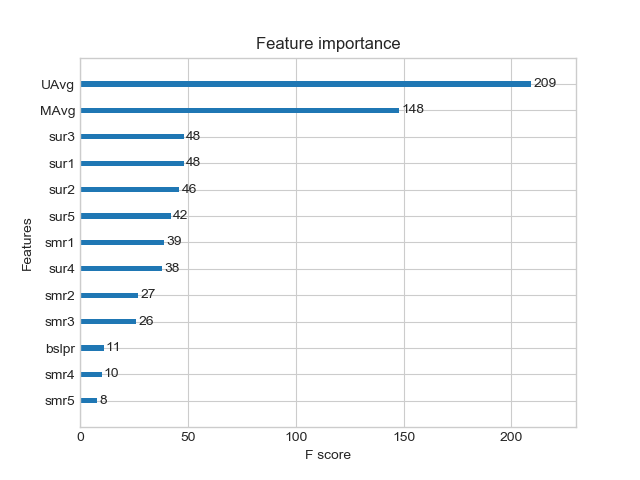

In [67]:
# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()


### Surprise KNNBaseline Predictor

In [68]:
from surprise import KNNBaseline

- KNN BASELINE
    - http://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline 
    
- PEARSON_BASELINE SIMILARITY
    - http://surprise.readthedocs.io/en/stable/similarities.html#surprise.similarities.pearson_baseline 
    
    
- SHRINKAGE
    - _2.2 Neighborhood Models_ in http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf 
    
    
    
- __predicted Rating__ : ( ___ based on User-User similarity ___ )

\begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)} \end{align}

- $\pmb{b_{ui}}$ -  _Baseline prediction_ of (user,movie) rating

- $ \pmb {N_i^k (u)}$ - Set of __K similar__ users (neighbours) of __user (u)__ who rated __movie(i)__  

- _sim (u, v)_ - __Similarity__ between users __u and v__  
    - Generally, it will be cosine similarity or Pearson correlation coefficient. 
    - But we use __shrunk Pearson-baseline correlation coefficient__, which is based on the pearsonBaseline similarity ( we take base line predictions instead of mean rating of user/item)
       
       
<br>       
       
       
- __ Predicted rating __ ( based on Item Item similarity ):
 \begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in N^k_u(j)} \text{sim}(i, j)} \end{align}

    -  ___Notations follows same as above (user user based predicted rating ) ___

#### Surprise KNNBaseline with user user similarities

In [69]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:45.574089 

Evaluating the model with train data..
time taken : 0:01:35.083653
---------------
Train Data
---------------
RMSE : 0.33642097416508826

MAPE : 9.145093375416348

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.073052
---------------
Test Data
---------------
RMSE : 1.0726493739667242

MAPE : 35.02094499698424

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:02:20.730794


#### Surprise KNNBaseline with movie movie similarities

In [70]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm

# 'user_based' : Fals => this considers the similarities of movies instead of users

sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:01.602712 

Evaluating the model with train data..
time taken : 0:00:08.920138
---------------
Train Data
---------------
RMSE : 0.32584796251610554

MAPE : 8.447062581998374

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.164560
---------------
Test Data
---------------
RMSE : 1.072758832653683

MAPE : 35.02269653015042

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:10.688408


### XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor

>First we will run XGBoost with predictions from both KNN's ( that uses User_User and Item_Item similarities along with our previous features.
<br>
>Then we will run XGBoost with just predictions form both knn models and preditions from our baseline model.

##### Prepare Train Data

In [71]:
# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,3.898982,3.93002,3.867958
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.371403,3.17733,3.076302


##### Prepare Test Data

In [72]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.581679,3.581679,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679


Training the model..
Done. Time taken : 0:00:05.036523

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0767793575625662
MAPE :  34.44745951378593


<IPython.core.display.Javascript object>


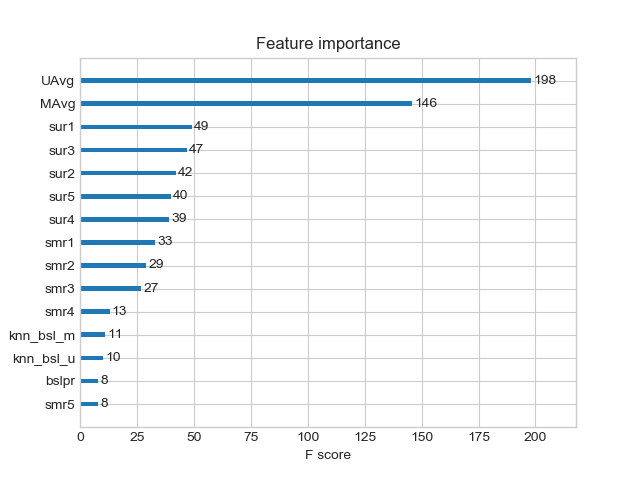

In [73]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# declare the model
xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()

### Matrix Factorization Techniques

#### SVD Matrix Factorization User Movie interactions

In [74]:
from surprise import SVD

http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD 

<br>

- __ Predicted Rating : __
    - 
    - $ \large  \hat r_{ui} = \mu + b_u + b_i + q_i^Tp_u $
    
        - $\pmb q_i$ - Representation of item(movie) in latent factor space
        
        - $\pmb p_u$ - Representation of user in new latent factor space
        
<br>

- A BASIC MATRIX FACTORIZATION MODEL in  https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf


<br>

- __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
    - $\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) $

In [75]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:08.870393 

Evaluating the model with train data..
time taken : 0:00:01.069112
---------------
Train Data
---------------
RMSE : 0.6574721240954099

MAPE : 19.704901088660478

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.135617
---------------
Test Data
---------------
RMSE : 1.0726046873826458

MAPE : 35.01953535988152

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:10.076138


#### SVD Matrix Factorization with implicit feedback from user ( user rated movies ) 

In [76]:
from surprise import SVDpp

- ----->  2.5 Implicit Feedback in http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf
    
    
<br>


- __ Predicted Rating : __
    - 
    - $ \large \hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
    |I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right) $ 
    
    
<br>


 - $ \pmb{I_u}$ --- the set of all items rated by user u

- $\pmb{y_j}$ --- Our new set of item factors that capture implicit ratings.  


- __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
    - $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + ||y_j||^2\right) $ 

In [77]:
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results

Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done. time taken : 0:02:12.531195 

Evaluating the model with train data..
time taken : 0:00:06.907490
---------------
Train Data
---------------
RMSE : 0.6032438403305899

MAPE : 17.49285063490268

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.145160
---------------
Test Data
---------------
RMSE : 1.0728491944183447

MAPE : 35.03817913919887

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:02:19.585841


### XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques 

##### Prepare Train Data

In [79]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,...,3.0,1.0,3.370370,4.092437,4,3.898982,3.93002,3.867958,4.303764,3.621664
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,...,3.0,5.0,3.555556,4.092437,3,3.371403,3.17733,3.076302,3.278967,3.538247


##### Prepare Test Data

In [80]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,5,3.581679,3.581679,3.581679,3.581679,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679,3.581679,3.581679


Training the model..
Done. Time taken : 0:00:06.263750

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0769599573828592
MAPE :  34.431788329400995


<IPython.core.display.Javascript object>


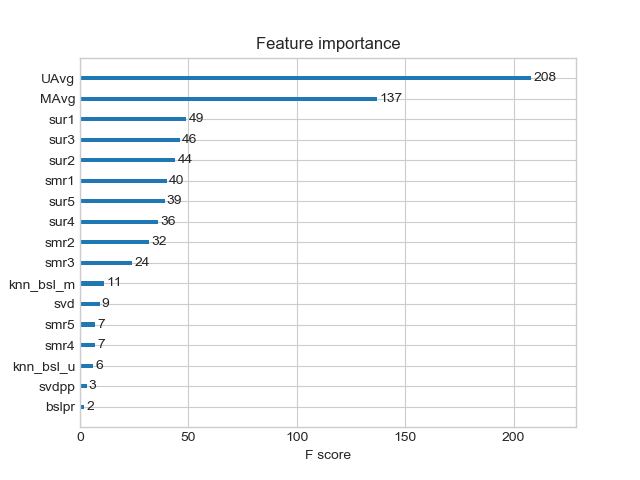

In [81]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']



xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

### XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques 

Training the model..
Done. Time taken : 0:00:02.707757

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0753047860953797
MAPE :  35.07058962951319


<IPython.core.display.Javascript object>


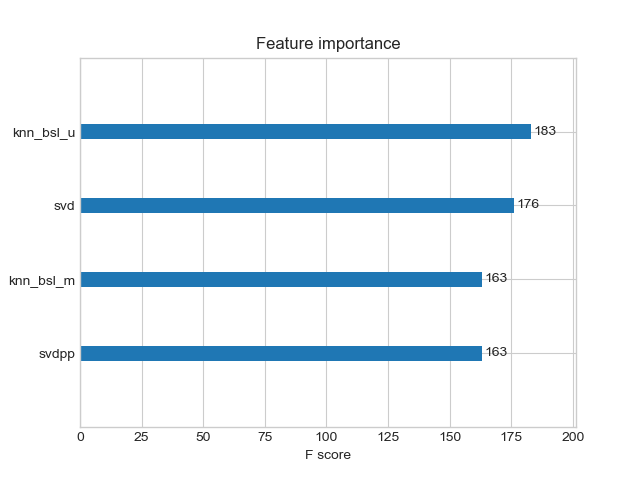

In [82]:
# prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']


xgb_all_models = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

## Comparision between models

In [87]:
# Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
pd.DataFrame(models_evaluation_test).to_csv('data_folder/small_sample_results.csv')
models = pd.read_csv('data_folder/small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()

svd               1.0726046873826458
knn_bsl_u         1.0726493739667242
knn_bsl_m          1.072758832653683
svdpp             1.0728491944183447
bsl_algo          1.0730330260516174
xgb_all_models    1.0753047860953797
first_algo         1.076373581778953
xgb_bsl           1.0765603714651855
xgb_knn_bsl       1.0767793575625662
xgb_final         1.0769599573828592
Name: rmse, dtype: object